In [1]:
% matplotlib inline

import numpy as np, nibabel as nib
import utils.plotting_lighterbg as plot
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import spearmanr, pearsonr
import pandas as pd
import statsmodels.formula.api as smf

sns.set_style('white')
sns.set_context('talk')

## Functional connectivity distance

In [2]:
ddir = '/Users/sabine/data/macaque/resting'
yerkes_dir ='/Users/sabine/data/Yerkes19'

In [3]:
# get 10k Yerkes19 files
cort = np.where(nib.load('%s/MacaqueYerkes19.L.atlasroi.10k_fs_LR.shape.gii' % ddir).darrays[0].data==1)[0]
coords = nib.load('%s/%s.L.inflated.10k_fs_LR.surf.gii' % (ddir, 'Willow')).darrays[0].data
faces = nib.load('%s/%s.L.inflated.10k_fs_LR.surf.gii' % (ddir, 'Willow')).darrays[1].data
sulc = nib.load('%s/%s.L.sulc.10k_fs_LR.shape.gii' % (ddir, 'Willow')).darrays[0].data

In [4]:
mdist = nib.load('%s/cifti.MEAN_meandist.10k_fs_LR.dscalar.nii' % ddir).get_data().squeeze()[:10242] # left hemi
mdist.shape

(10242,)

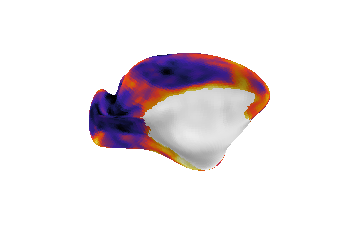

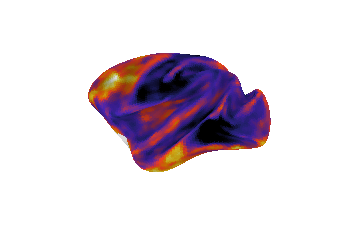

In [5]:
for azim in [0, 180]:
    img = plot.plot_surf_stat_map(coords, faces,
                                  mdist, mask=cort,
                                  bg_map=sulc,
                                  bg_on_stat=True,
                                  alpha=1,
                                  vmin=10,
                                  vmax=30,
                                  azim=azim,
                                  cmap='CMRmap')
    
    
    plt.savefig('/Users/sabine/Downloads/surf_func_condist_%s' % (azim), dpi=300)

## Distance from primary cortex

In [6]:
import gdist
from surfdist.utils import surf_keep_cortex, translate_src, recort

def dist_calc_fast(src, cortex, vertices, triangles, surf):
    src_new = translate_src(src, cortex)
    data = gdist.compute_gdist(vertices, triangles, source_indices=src_new)
    dist = recort(data, surf, cortex)
    del data
    return dist

In [7]:
# surf midthickness for dist calc

f_surf_mid = '%s/MacaqueYerkes19.L.midthickness.10k_fs_LR.surf.gii' % ddir
coords_mid = nib.load(f_surf_mid).darrays[0].data
faces_mid = nib.load(f_surf_mid).darrays[1].data
surf_mid = tuple((coords_mid, faces_mid))

In [8]:
vertices, triangles = surf_keep_cortex((coords_mid, faces_mid), cort)

In [9]:
atlas = nib.load('%s/L.MarkovCC12_M132_91-area.10k_fs_LR.label.gii' % ddir)#.darrays[0].data

In [10]:
#atlas.labeltable.get_labels_as_dict()
prim_names = ['V1', 'CORE', 'F1', '3']
prim_keys = [83, 36, 39, 3]

In [11]:
prim_dist = np.empty((len(prim_keys), 
                      coords.shape[0]))

for n, key in enumerate(prim_keys):
    prim_dist[n] = dist_calc_fast(np.where(atlas.darrays[0].data==key)[0], 
                                  cort, vertices, triangles, surf_mid)
    
prim_dist = np.min(prim_dist, axis=0)

In [12]:
print prim_dist.min(), prim_dist.max()

0.0 34.880611646570905


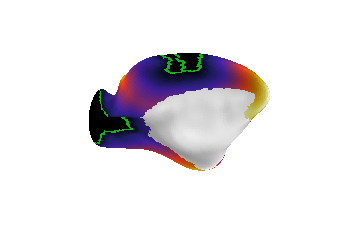

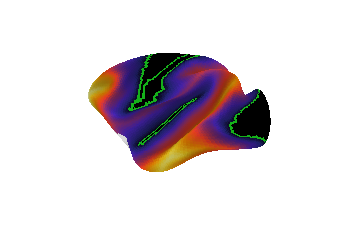

In [13]:
labels_prim = [np.where(atlas.darrays[0].data==key)[0] for key in prim_keys]

for azim in [0, 180]:
    img = plot.plot_surf_stat_map(coords, faces,
                                  prim_dist, mask=cort,
                                  labels = labels_prim, 
                                  azim=azim,
                                  bg_map=sulc, bg_on_stat=True, 
                                  cmap='CMRmap')

## Average values per area

In [14]:
annot = np.array([atlas.labeltable.get_labels_as_dict()[key] for key in atlas.darrays[0].data])

df = pd.DataFrame({'area': annot, 
                   'meandist': mdist, 
                   'primdist': prim_dist})

df['area'] = df['area'].astype(str).values

print df.shape
df.head()

(10242, 3)


,area,meandist,primdist
0,23,19.625196,8.076127
1,V6A,11.038814,11.427151
2,2,14.217127,7.486708
3,F1,16.657005,0.000000
4,V1,19.430664,0.000000


In [15]:
df = df.groupby('area').mean().reset_index()

order = df.sort_values('primdist').index
order = [str(area) for area in order]

df.sort_values('primdist', ascending=False).head(15)

,area,meandist,primdist
1,10,20.929880,33.739209
5,14,19.249905,30.259462
16,32,22.155176,29.822937
2,11,20.747677,29.399108
21,46v,21.082594,28.705032
12,25,21.125153,27.926912
31,9,20.208588,27.839381
20,46d,20.157793,26.336519
79,TEpd,21.750528,25.994289
10,24c,17.900663,25.963196


# STATS
## Relationship of connectivity distance with distance from primary cortex

In [16]:
model = smf.ols(formula='meandist ~ primdist', data=df[df.area!='???']).fit()
print model.summary()

                            OLS Regression Results                            
Dep. Variable:               meandist   R-squared:                       0.174
Model:                            OLS   Adj. R-squared:                  0.165
Method:                 Least Squares   F-statistic:                     18.78
Date:                Mon, 08 Oct 2018   Prob (F-statistic):           3.85e-05
Time:                        15:10:32   Log-Likelihood:                -238.13
No. Observations:                  91   AIC:                             480.3
Df Residuals:                      89   BIC:                             485.3
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     14.8403      0.716     20.740      0.0

In [17]:
model.pvalues

Intercept    7.635903e-36
primdist     3.854029e-05
dtype: float64

/Users/sabine/anaconda2/envs/distconnect/lib/python2.7/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


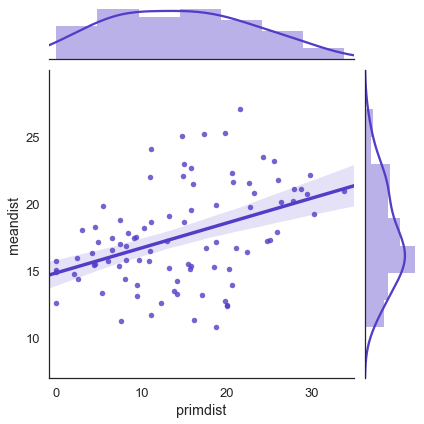

In [18]:
g = sns.jointplot(x="primdist", 
                  y="meandist", 
                  data=df[df.area!='???'],
                  kind='reg', 
                  color="#533cc6", 
                  xlim=(-.9,35), 
                  ylim=(7,30),
                  stat_func=None,
                  scatter_kws={"s": 30})


_ = plt.xticks([0,10,20,30])
_ = plt.yticks([10,15, 20,25])

g.savefig('/Users/sabine/Downloads/relationship_func.png', dpi=300)

In [19]:
from adjustText import adjust_text
import matplotlib as mpl
mpl.rcParams['svg.fonttype'] = 'none'

sns.set_style('white')
sns.set_context('paper')

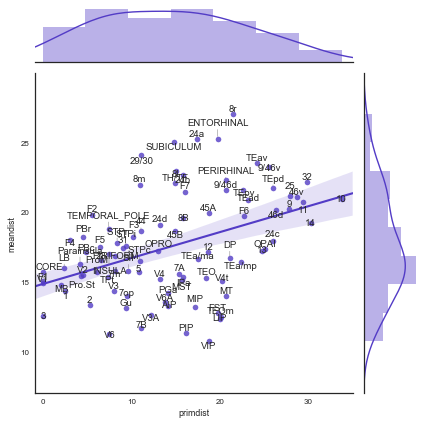

In [20]:
g = sns.jointplot(x="primdist", 
                  y="meandist", 
                  data=df[df.area!='???'],
                  kind='reg', 
                  color="#533cc6", 
                  xlim=(-.9,35), 
                  ylim=(7,30),
                  stat_func=None)#, scatter_kws={"s": 30})

_ = plt.xticks([0,10,20,30])
_ = plt.yticks([10,15, 20,25])

texts = [plt.text(df[df.area!='???'].primdist[i], 
                  df[df.area!='???'].meandist[i], 
                  '%s' % df[df.area!='???'].area[i], 
                  ha='center', 
                  va='center') for i in df[df.area!='???'].index]

adjust_text(texts, 
            arrowprops = dict(arrowstyle="-", color='grey', lw=0.5), 
            autoalign = None, 
            only_move={'points':'y', 'text':'y'}, 
            force_text=(0.5, 0.25), 
            expand_text=(1.5, 1.2))#, autoalign='')

g.savefig('/Users/sabine/Downloads/relationship_func_labelled.svg', dpi=300)

### Any serious outliers?

Text(0,0.5,'residuals')

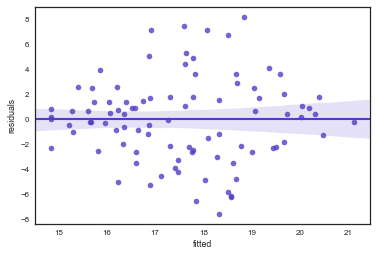

In [21]:
sns.regplot(model.fittedvalues, model.resid, color="#533cc6", )
plt.xlabel('fitted')
plt.ylabel('residuals')
#plt.savefig('/Users/sabine/Downloads/residuals_against_fitted.png', dpi=300)

In [22]:
df.loc[df.area!='???','func_resid'] = model.resid
df.loc[df.area!='???','func_stud_resid'] = model.outlier_test()['student_resid']
df.loc[df.area!='???','func_unadj_p'] = model.outlier_test()['unadj_p']
df.loc[df.area!='???','func_bonf_p'] = model.outlier_test()['bonf(p)']

In [23]:
df[df.area!='???'].sort_values('func_stud_resid').head()

,area,meandist,primdist,func_resid,func_stud_resid,func_unadj_p,func_bonf_p
91,VIP,10.753365,18.731855,-7.574329,-2.333030,0.021927,1.0
62,PIP,11.330593,16.159026,-6.518103,-1.989158,0.049790,1.0
51,LIP,12.343019,20.006615,-6.222003,-1.899545,0.060768,1.0
74,TEOm,12.470252,20.080136,-6.108459,-1.863631,0.065708,1.0
46,FST,12.751892,19.763891,-5.767941,-1.755471,0.082659,1.0


In [24]:
df[df.area!='???'].sort_values('func_stud_resid').tail()

,area,meandist,primdist,func_resid,func_stud_resid,func_unadj_p,func_bonf_p
38,ENTORHINAL,25.282253,19.748706,6.765247,2.072652,0.041130,1.0
8,24a,25.234974,17.375075,7.159879,2.196291,0.030700,1.0
13,29/30,24.083555,11.132262,7.170720,2.200417,0.030396,1.0
71,SUBICULUM,25.069300,14.792896,7.474944,2.296962,0.023994,1.0
30,8r,27.054497,21.518249,8.208045,2.549120,0.012532,1.0


In [25]:
df.to_pickle('./data/df_func.pkl') # for combining with struct later